<p align="center"> <img src="https://www.motorbiscuit.com/wp-content/uploads/2020/03/Used-Car-Dealership-Getty-5.jpg"> </p>

# Predicting used cars prices in the Canadian market

When it comes to purchasing a used car, budget constraints are a primary consideration. Prices can vary due to various factors, and the experience differs significantly from buying a new vehicle. The initial search is crucial, and buyers rely on online information and reviews. However, determining if an offer is **fair** or **overpriced** can be challenging. Leveraging machine learning and data analysis can simplify this process and offer **unbiased** advice to shoppers.

In this notebook, I'll explore and implement various machine learning algorithms to predict used car prices in Canada. The journey begins with an exploratory data analysis (EDA) on a dataset obtained from **Kaggle**. Subsequently, I'll perform feature engineering to train and fine-tune machine learning regression algorithms.

## 1- Download used cars market data  
In this section, we will install and import all the libraries that will be used throughout the notebook. Following that, we'll proceed to download a substantial dataset comprising listings for used cars.

In [6]:
# install and import the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pickle # to save the results
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error
import os
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
import xgboost
print(xgboost.__version__) # !!! important : must be 1.2.1, if not restart kernel.

2.0.3


In [7]:
!pip install opendatasets --upgrade --quiet

In [8]:
import opendatasets as od

In [9]:
# download data

filepath = '.\data'
url = 'https://www.kaggle.com/rupeshraundal/marketcheck-automotive-data-us-canada?select=ca-dealers-used.csv'
if not(os.path.exists(filepath)):
    od.download_kaggle_dataset(url, filepath)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asadayub2211
Your Kaggle Key: ··········


100%|██████████| 420M/420M [00:04<00:00, 94.2MB/s]


In [10]:
# read csv data
canada_ds = pd.read_csv(filepath+'/marketcheck-automotive-data-us-canada/ca-dealers-used.csv', low_memory=False)
canada_ds.sample(3)

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
12754,84e6c142-b594,2C4RDGDG2KR687406,25945.0,68546.0,S59467A,2019.0,Dodge,Grand Caravan,Leather,NaN,...,FWD,Automatic,NaN,NaN,NaN,sherwood chevrolet inc,550 Brand Road,Saskatoon,SK,S7J 5J3
350518,757b0ed3-afe8,5UXFG4C59AL226640,19900.0,66980.0,6640,2010.0,BMW,X6,40i,SUV,...,4WD,Automatic,Premium Unleaded,3.0,I,sinone auto,4211 Number 3 Road,Richmond,BC,V6X 2C3
45607,8fa811fa-c1bb,JA4JT3AX0BU609300,10995.0,137163.0,#20104A,2011.0,Mitsubishi,Outlander,LS,NaN,...,4WD,Automatic,NaN,NaN,NaN,maison kia dolbeau-mistassini,42 Boul Saint-michel,Dolbeau-mistassini,QC,G8L 5J3


In [11]:
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393603 entries, 0 to 393602
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            393603 non-null  object 
 1   vin           393603 non-null  object 
 2   price         358486 non-null  float64
 3   miles         366590 non-null  float64
 4   stock_no      365929 non-null  object 
 5   year          393586 non-null  float64
 6   make          393603 non-null  object 
 7   model         388809 non-null  object 
 8   trim          354824 non-null  object 
 9   body_type     359578 non-null  object 
 10  vehicle_type  355365 non-null  object 
 11  drivetrain    354608 non-null  object 
 12  transmission  357922 non-null  object 
 13  fuel_type     322790 non-null  object 
 14  engine_size   320950 non-null  float64
 15  engine_block  320439 non-null  object 
 16  seller_name   391371 non-null  object 
 17  street        385674 non-null  object 
 18  city

In [12]:
canada_ds.isna().sum()

id                  0
vin                 0
price           35117
miles           27013
stock_no        27674
year               17
make                0
model            4794
trim            38779
body_type       34025
vehicle_type    38238
drivetrain      38995
transmission    35681
fuel_type       70813
engine_size     72653
engine_block    73164
seller_name      2232
street           7929
city             7774
state            7836
zip              7769
dtype: int64

We choose to drop all the rows missing pieces of information since we still will have a sufficient amount of data. Before that, we will drop all the columns that won't be used. This will allow to keep more rows in the used columns and decrease the complexity by reducing the number of features.

In [13]:
unused_columns = ['id', 'stock_no','seller_name', 'street', 'engine_size',
                'zip','fuel_type', 'engine_block']
canada_ds.drop(unused_columns,axis = 1, inplace=True)
canada_ds.dropna(inplace=True)

Now, we remove all duplicates having the same `vin` number.

In [14]:
canada_ds.drop_duplicates('vin', inplace=True)
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158493 entries, 0 to 393602
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           158493 non-null  object 
 1   price         158493 non-null  float64
 2   miles         158493 non-null  float64
 3   year          158493 non-null  float64
 4   make          158493 non-null  object 
 5   model         158493 non-null  object 
 6   trim          158493 non-null  object 
 7   body_type     158493 non-null  object 
 8   vehicle_type  158493 non-null  object 
 9   drivetrain    158493 non-null  object 
 10  transmission  158493 non-null  object 
 11  city          158493 non-null  object 
 12  state         158493 non-null  object 
dtypes: float64(3), object(10)
memory usage: 16.9+ MB


The resulting data frame contains more than 158000 records, with no duplicates and no missing fields.  
Next, we display the details about the column `state`.

In [15]:
#fix state information
canada_ds.state.unique()

array(['NB', 'QC', 'BC', 'ON', 'AB', 'MB', 'SK', 'NS', 'PE', 'NL', 'YT',
       'NC', 'OH', 'SC'], dtype=object)

Some data points are not labeled correctly. `OH`, `NC` and `SC` do not represent canadian provinces. To fix this problem, we investigate the `city` values for these "states".

In [16]:
canada_ds[canada_ds['state']=='OH']['city'].unique()

array(['Woodbridge'], dtype=object)

After some search, it turns out that *Woodbridge* is a city in Ontario. We just have to replace the values in the data frame.

In [17]:
canada_ds['state'].replace('OH','ON',inplace=True)

We proceed the same way with `SC` and `NC`. Result: `NC` doesn't contain any record in a canadian city, and `SC` contains records in **Quebec city, QC**. We clean the dataset accordingly.

In [18]:
canada_ds.drop(index = canada_ds[canada_ds.state=='NC'].index, inplace=True)
canada_ds['state'].replace('SC','QC',inplace=True)

After cleaning this column, we consider the `year` data. This column provides the model year of the car.

In [19]:
canada_ds['year'].describe()

count    158478.000000
mean       2016.341688
std           3.234555
min        1990.000000
25%        2015.000000
50%        2017.000000
75%        2019.000000
max        2022.000000
Name: year, dtype: float64

The listings we are using are snapshots of the used car market in 2021, with some cars labeled as from year 2022. This is a common practice in the automotive industry, known as the **model year**. We could create a column `age` using the data from `year`.

In [20]:
# create Age column
canada_ds['age'] = 2022- canada_ds['year']

One last modification to our data is to remove outliers, by limiting the age, price and mileage of cars. This will be particularly useful during the training process.

In [21]:
# filter very expensive and very old cars (outliers)
canada_ds=canada_ds[canada_ds['age']<25]
canada_ds=canada_ds[canada_ds['price']<100000]
canada_ds=canada_ds[canada_ds['miles']<200000]
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151994 entries, 16 to 393599
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           151994 non-null  object 
 1   price         151994 non-null  float64
 2   miles         151994 non-null  float64
 3   year          151994 non-null  float64
 4   make          151994 non-null  object 
 5   model         151994 non-null  object 
 6   trim          151994 non-null  object 
 7   body_type     151994 non-null  object 
 8   vehicle_type  151994 non-null  object 
 9   drivetrain    151994 non-null  object 
 10  transmission  151994 non-null  object 
 11  city          151994 non-null  object 
 12  state         151994 non-null  object 
 13  age           151994 non-null  float64
dtypes: float64(4), object(10)
memory usage: 17.4+ MB


## 2- Exploratory Data Analysis

In this section, we will display some graphs to get an intuition about the data that will be used to design the prediction algorithms. The first scatterplot shows the relationship between mileage, age and price of used cars.

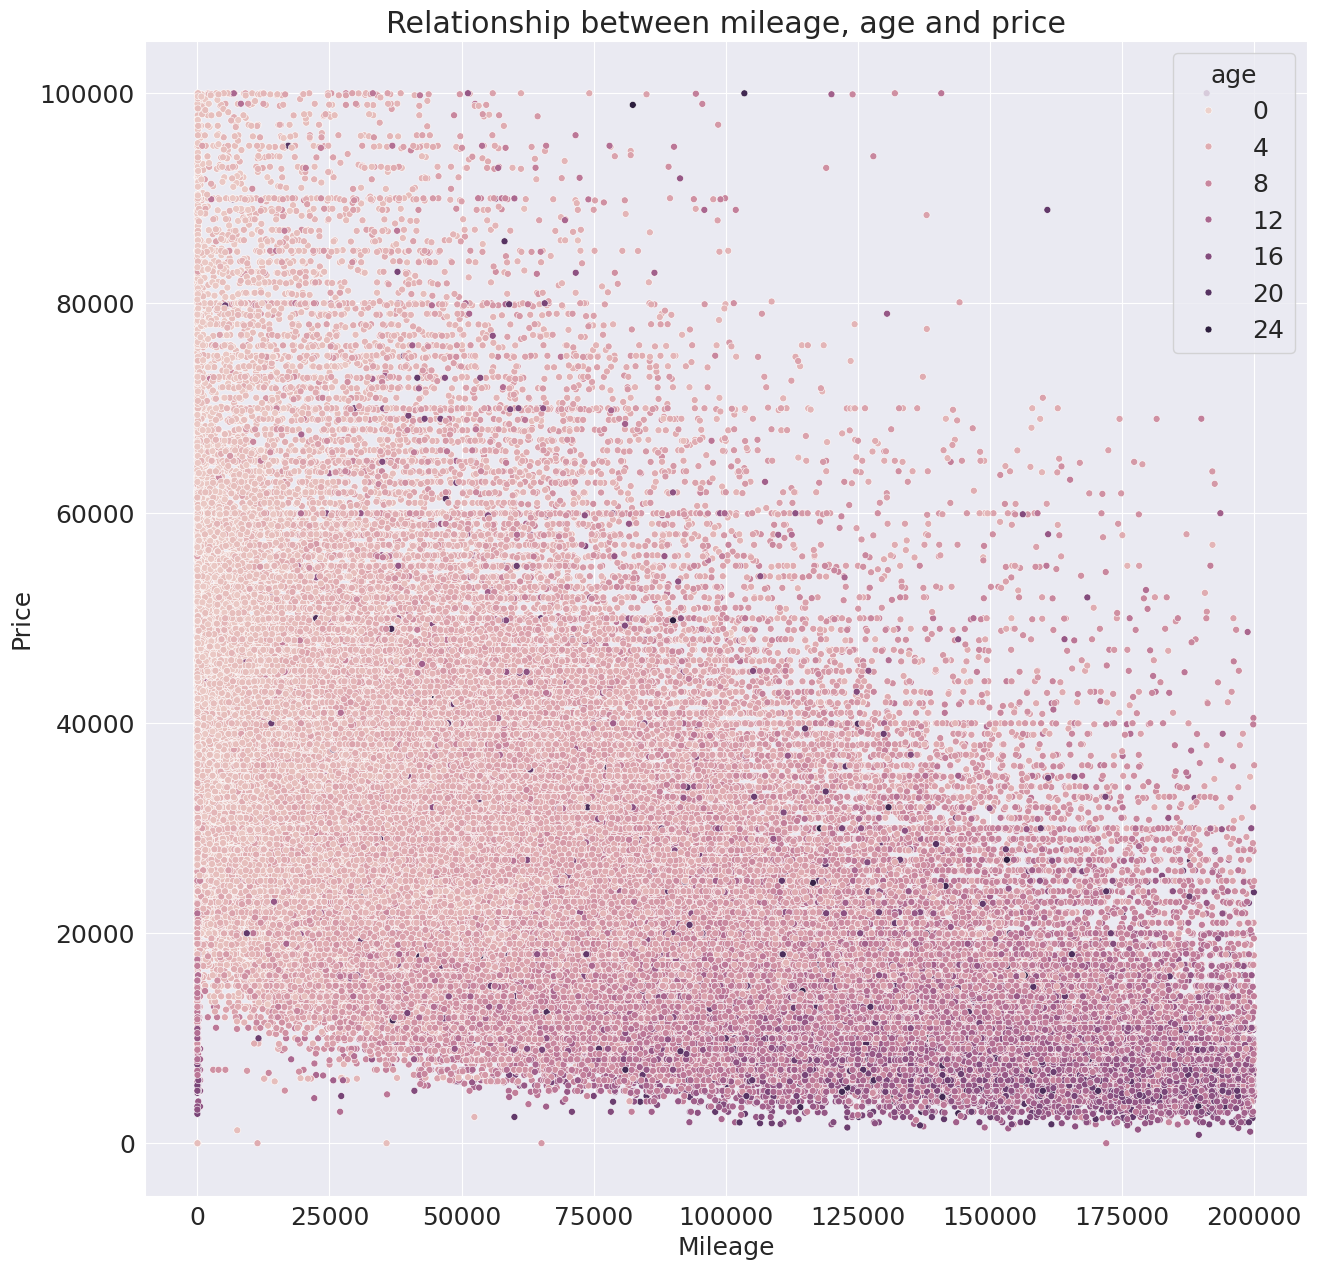

In [22]:
matplotlib.rcParams['figure.figsize'] = (15, 15)
fig = sns.scatterplot(y ='price',x='miles', hue = 'age',data =canada_ds,s=25);
fig.set(xlabel = 'Mileage', ylabel = 'Price', title = 'Relationship between mileage, age and price');

In general, expensive cars are either recent or have lower mileage. There are some exceptions (consider the dark points) where some old cars can hold a high value, regardless of the mileage.  
The following graphs show the most and the least expensive car makes in the market.

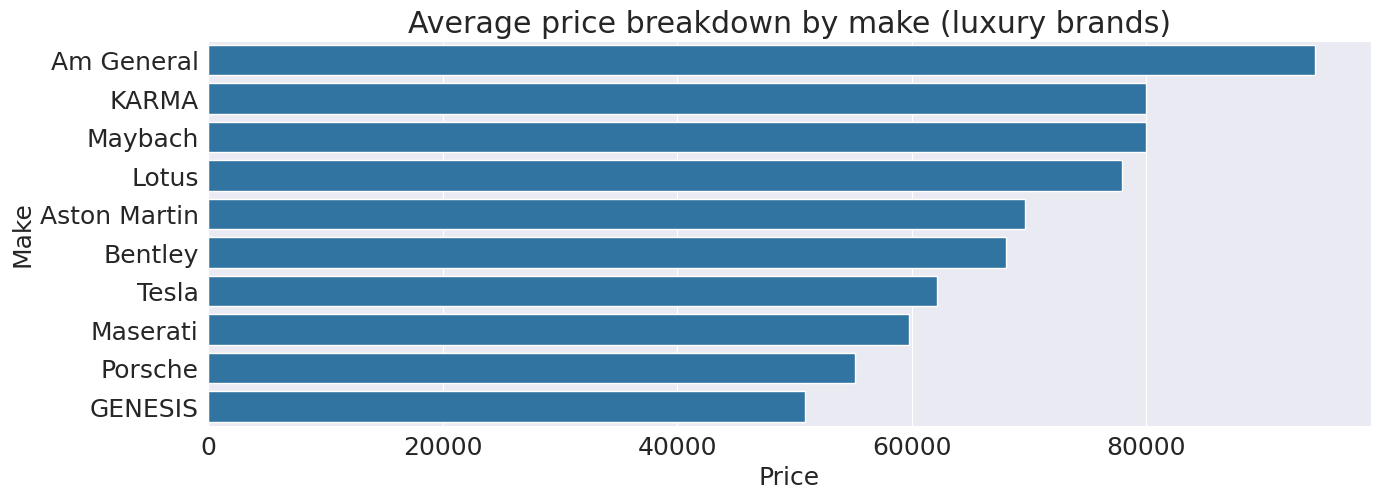

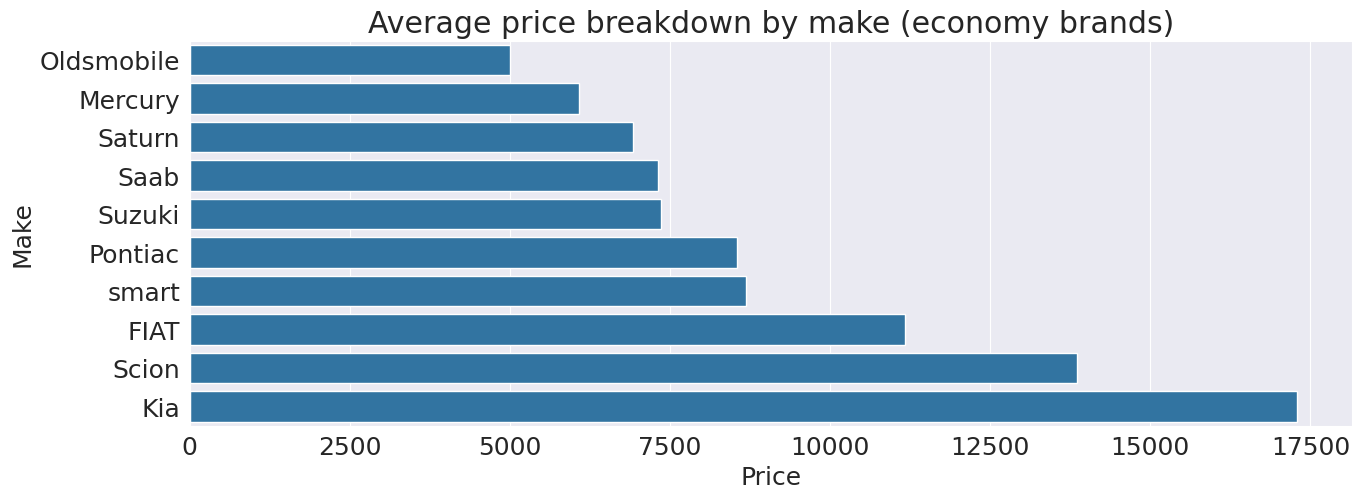

In [23]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (luxury brands)');
plt.figure()
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=True).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (economy brands)');

Many electric car brands are in the top-10 most expensive cars. This is mainly due to their recent appearance in the market.  
Let's explore which drivetrain is more common in Canada.

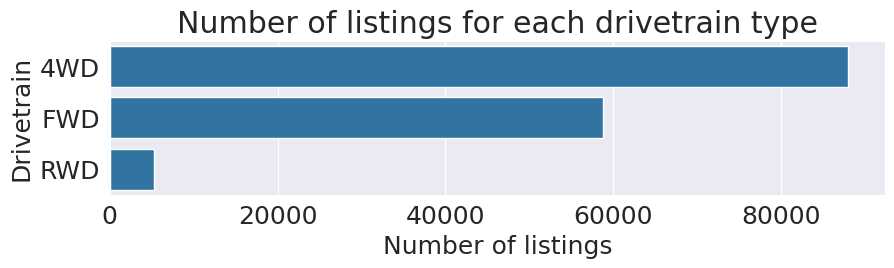

In [24]:
matplotlib.rcParams['figure.figsize'] = (10, 2)
column = 'drivetrain'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Drivetrain', title = 'Number of listings for each drivetrain type');

With no surprise, `4wd` cars are very common in Canada, due to its famously harsh winter!  
Next, we show the ratio of `Automatic` transmissions in the canadian market.

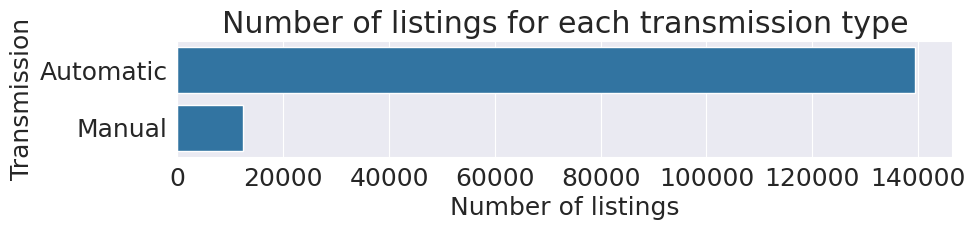

In [25]:
matplotlib.rcParams['figure.figsize'] = (10, 1.5)
column = 'transmission'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Transmission', title = 'Number of listings for each transmission type');

In some provinces, used vehicles are more expensive due to the cost of living, taxes, and emission control. This is shown in the next graph.


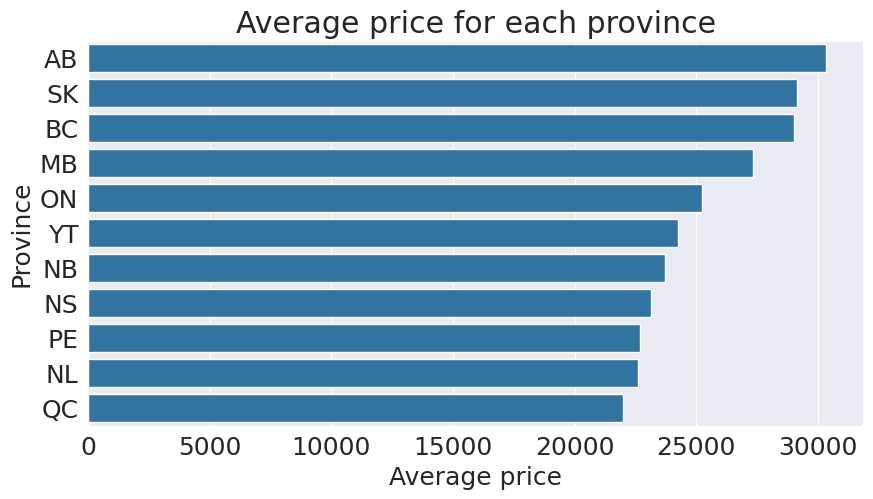

In [26]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Average price', ylabel = 'Province', title = 'Average price for each province');

The market share of each province is directly related to its population size. As shown on the next plot, Ontario has the highest number of listings (and the largest population).

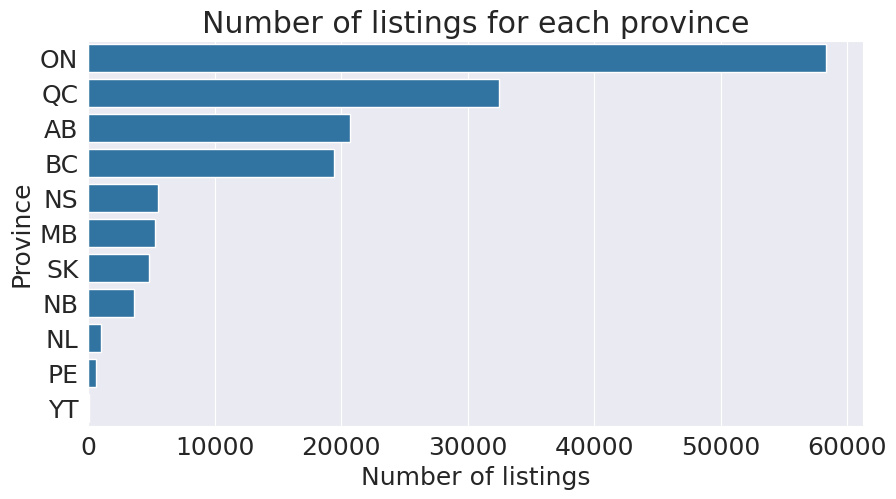

In [27]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Province', title = 'Number of listings for each province');

## 3- Prepare data for machine learning

After cleaning the data, we select the most suitable features to predict/evaluate a used car price. Here is a list of available features in the dataframe:

In [28]:
canada_ds.columns

Index(['vin', 'price', 'miles', 'year', 'make', 'model', 'trim', 'body_type',
       'vehicle_type', 'drivetrain', 'transmission', 'city', 'state', 'age'],
      dtype='object')

The output of our model will be obviously the **price**. We will not use the **VIN** number, and split the remaining features into two classes: numeric and categorical columns.  
Note that an important piece of information is missing here: **the car condition**. In the used car market, two very identical vehicles can have large price differences due to previous maintenance, accident history, rust, and interior condition. This detail will affect the precision of the prediction process.

In [29]:
target_cols = ['price']
features_num_cols = ['miles', 'age',]
features_cat_cols = ['make', 'model', 'drivetrain', 'transmission','state', 'city','trim','body_type','vehicle_type']

In [30]:
raw_data = canada_ds[features_num_cols+features_cat_cols+target_cols].copy()
avg_price = raw_data['price'].mean()
print('Average price is ${:.2f}'.format(avg_price))

Average price is $25771.99


The model output (*price*), has an average of $25k. The performance metrics of the regressions will be evaluated by comparison to this baseline value.

First, we split the data into training, validation and testing sets.

In [31]:
# split train, test and val
# remove annoying warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import train_test_split
trainval_data, test_data = train_test_split(raw_data, test_size = 0.2)
train_data, val_data = train_test_split(trainval_data, test_size = 0.25)

The numeric features will be scaled using *scikit learn* minmax scaler.

In [32]:
# normalize numeric inputs
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(raw_data[features_num_cols])
train_data[features_num_cols] = scaler.transform(train_data[features_num_cols])
test_data[features_num_cols] = scaler.transform(test_data[features_num_cols])
val_data[features_num_cols] = scaler.transform(val_data[features_num_cols])

The categorical features will be transformed via a one hot encoding strategy.

In [33]:
# one hot encoding categorical inputs
from sklearn.preprocessing import OneHotEncoder
# the global encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_data[features_cat_cols])
new_one_hot_cols = [] #list(encoder.get_feature_names(features_cat_cols))

for column in tqdm(features_cat_cols):
  encoder_i = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_data[[column]])
  new_one_hot_cols_i = list(encoder_i.get_feature_names_out([column]))
  train_data[new_one_hot_cols_i] = encoder_i.transform(train_data[[column]])
  test_data[new_one_hot_cols_i] = encoder_i.transform(test_data[[column]])
  val_data[new_one_hot_cols_i] = encoder_i.transform(val_data[[column]])
  new_one_hot_cols += new_one_hot_cols_i

  0%|          | 0/9 [00:00<?, ?it/s]

These transformations create new features. Here is the total number of features.

In [34]:
new_one_hot_cols

['make_Acura',
 'make_Alfa Romeo',
 'make_Am General',
 'make_Aston Martin',
 'make_Audi',
 'make_BMW',
 'make_Bentley',
 'make_Buick',
 'make_Cadillac',
 'make_Chevrolet',
 'make_Chrysler',
 'make_Dodge',
 'make_FIAT',
 'make_Ford',
 'make_GENESIS',
 'make_GMC',
 'make_Honda',
 'make_Hummer',
 'make_Hyundai',
 'make_INFINITI',
 'make_Jaguar',
 'make_Jeep',
 'make_KARMA',
 'make_Kia',
 'make_Land Rover',
 'make_Lexus',
 'make_Lincoln',
 'make_Lotus',
 'make_MINI',
 'make_Maserati',
 'make_Maybach',
 'make_Mazda',
 'make_Mercedes-Benz',
 'make_Mercury',
 'make_Mitsubishi',
 'make_Nissan',
 'make_Oldsmobile',
 'make_Plymouth',
 'make_Pontiac',
 'make_Porsche',
 'make_RAM',
 'make_Saab',
 'make_Saturn',
 'make_Scion',
 'make_Subaru',
 'make_Suzuki',
 'make_Tesla',
 'make_Toyota',
 'make_Volkswagen',
 'make_Volvo',
 'make_smart',
 'model_1 Series',
 'model_124 Spider',
 'model_2 Series',
 'model_200',
 'model_3 Series',
 'model_3-Series',
 'model_300',
 'model_350Z',
 'model_350Z Roadster'

In [35]:
print('number of features ={}'.format(len(features_num_cols + new_one_hot_cols)))

number of features =2810


The last step will be to create input and output dataframes for each set.

In [38]:
# create input and output dataframes
train_inputs = train_data[features_num_cols + new_one_hot_cols]
test_inputs = test_data[features_num_cols + new_one_hot_cols]
val_inputs = val_data[features_num_cols + new_one_hot_cols]

train_output = train_data[target_cols]
test_output = test_data[target_cols]
val_output = val_data[target_cols]

In [39]:
train_inputs

,miles,age,make_Acura,make_Alfa Romeo,make_Am General,make_Aston Martin,make_Audi,make_BMW,make_Bentley,make_Buick,...,body_type_Minivan,body_type_Passenger Van,body_type_Pickup,body_type_Roadster,body_type_SUV,body_type_Sedan,body_type_Targa,body_type_Wagon,vehicle_type_Car,vehicle_type_Truck
259305,0.281991,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
354176,0.337062,0.291667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
217017,0.934005,0.291667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
366701,0.201186,0.166667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
191150,0.277886,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143401,0.335607,0.208333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
349784,0.201066,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
191920,0.117656,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
156313,0.446257,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## 4- Predicting the price using machine learning

In this part, we will train and tune various machine learning regression algorithms. The first method is based on gradient boosting, using the library **XGBoost**.

### 4-1 Regression using XGBoost

In [40]:
# import XGBoost
from xgboost import XGBRegressor

**XGBoost** has multiple hyperparameters. In this notebook, we will tune two parameters:
- max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
- n_estimators: Number of trees. A high number of trees will most likely lead to overfitting.  

We will use a grid search method to find the optimal values of these hyperparameters.  
The next cells request large memory amount, which is not an option with Google Colab (free version). I have done the computations on my local machine, and imported the files with the notebook in order to save time.  

In [41]:
model = XGBRegressor(random_state= 42, n_jobs=-1, n_estimators= 20, max_depth=4)

In [42]:
%%time
model.fit(train_inputs, train_output)

CPU times: user 57.7 s, sys: 316 ms, total: 58 s
Wall time: 32.7 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [43]:
# execute only on local machine or colab pro, if not available, skip this cell
results=[]
for max_depth in tqdm(range(5,11)):
    for n_estimators in tqdm(range(50,601,50)):
        model = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth)
        model.fit(train_inputs, train_output)
        train_preds = model.predict(train_inputs)
        val_preds = model.predict(val_inputs)
        error_train = mean_squared_error(train_output, train_preds, squared=False)
        error_val = mean_squared_error(val_output, val_preds, squared=False)
        print('max_depth={} **'.format(max_depth),'n_estimators={} **'.format(n_estimators),"RMS_error_train = {:.2f} ** RMS_error_val = {:.2f}".format(error_train,error_val))
        results.append([max_depth,n_estimators,error_train, error_val])

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

max_depth=5 ** n_estimators=50 ** RMS_error_train = 5591.99 ** RMS_error_val = 5797.52
max_depth=5 ** n_estimators=100 ** RMS_error_train = 4647.80 ** RMS_error_val = 4927.07
max_depth=5 ** n_estimators=150 ** RMS_error_train = 4119.06 ** RMS_error_val = 4428.41
max_depth=5 ** n_estimators=200 ** RMS_error_train = 3793.46 ** RMS_error_val = 4142.22
max_depth=5 ** n_estimators=250 ** RMS_error_train = 3558.56 ** RMS_error_val = 3944.59
max_depth=5 ** n_estimators=300 ** RMS_error_train = 3366.86 ** RMS_error_val = 3795.61
max_depth=5 ** n_estimators=350 ** RMS_error_train = 3213.44 ** RMS_error_val = 3675.98
max_depth=5 ** n_estimators=400 ** RMS_error_train = 3105.61 ** RMS_error_val = 3598.12
max_depth=5 ** n_estimators=450 ** RMS_error_train = 2985.22 ** RMS_error_val = 3505.92
max_depth=5 ** n_estimators=500 ** RMS_error_train = 2883.74 ** RMS_error_val = 3440.62
max_depth=5 ** n_estimators=550 ** RMS_error_train = 2814.60 ** RMS_error_val = 3397.00
max_depth=5 ** n_estimators=600 *

  0%|          | 0/12 [00:00<?, ?it/s]

max_depth=6 ** n_estimators=50 ** RMS_error_train = 5118.43 ** RMS_error_val = 5357.40
max_depth=6 ** n_estimators=100 ** RMS_error_train = 4182.80 ** RMS_error_val = 4504.85
max_depth=6 ** n_estimators=150 ** RMS_error_train = 3715.98 ** RMS_error_val = 4105.94
max_depth=6 ** n_estimators=200 ** RMS_error_train = 3405.68 ** RMS_error_val = 3849.48
max_depth=6 ** n_estimators=250 ** RMS_error_train = 3181.12 ** RMS_error_val = 3689.66
max_depth=6 ** n_estimators=300 ** RMS_error_train = 3034.06 ** RMS_error_val = 3582.98
max_depth=6 ** n_estimators=350 ** RMS_error_train = 2911.73 ** RMS_error_val = 3504.49
max_depth=6 ** n_estimators=400 ** RMS_error_train = 2771.31 ** RMS_error_val = 3415.42
max_depth=6 ** n_estimators=450 ** RMS_error_train = 2689.87 ** RMS_error_val = 3372.62
max_depth=6 ** n_estimators=500 ** RMS_error_train = 2602.45 ** RMS_error_val = 3328.56
max_depth=6 ** n_estimators=550 ** RMS_error_train = 2528.00 ** RMS_error_val = 3290.08
max_depth=6 ** n_estimators=600 *

  0%|          | 0/12 [00:00<?, ?it/s]

max_depth=7 ** n_estimators=50 ** RMS_error_train = 4703.02 ** RMS_error_val = 5017.54
max_depth=7 ** n_estimators=100 ** RMS_error_train = 3860.13 ** RMS_error_val = 4304.69
max_depth=7 ** n_estimators=150 ** RMS_error_train = 3459.57 ** RMS_error_val = 3976.14
max_depth=7 ** n_estimators=200 ** RMS_error_train = 3149.66 ** RMS_error_val = 3741.69
max_depth=7 ** n_estimators=250 ** RMS_error_train = 2930.24 ** RMS_error_val = 3593.97
max_depth=7 ** n_estimators=300 ** RMS_error_train = 2794.74 ** RMS_error_val = 3516.79
max_depth=7 ** n_estimators=350 ** RMS_error_train = 2654.60 ** RMS_error_val = 3436.65
max_depth=7 ** n_estimators=400 ** RMS_error_train = 2561.74 ** RMS_error_val = 3387.75
max_depth=7 ** n_estimators=450 ** RMS_error_train = 2477.13 ** RMS_error_val = 3344.02
max_depth=7 ** n_estimators=500 ** RMS_error_train = 2416.04 ** RMS_error_val = 3318.25
max_depth=7 ** n_estimators=550 ** RMS_error_train = 2331.81 ** RMS_error_val = 3271.72
max_depth=7 ** n_estimators=600 *

  0%|          | 0/12 [00:00<?, ?it/s]

max_depth=8 ** n_estimators=50 ** RMS_error_train = 4391.75 ** RMS_error_val = 4794.63
max_depth=8 ** n_estimators=100 ** RMS_error_train = 3489.42 ** RMS_error_val = 4040.44
max_depth=8 ** n_estimators=150 ** RMS_error_train = 3065.64 ** RMS_error_val = 3725.03
max_depth=8 ** n_estimators=200 ** RMS_error_train = 2827.01 ** RMS_error_val = 3562.35
max_depth=8 ** n_estimators=250 ** RMS_error_train = 2648.61 ** RMS_error_val = 3463.37
max_depth=8 ** n_estimators=300 ** RMS_error_train = 2507.83 ** RMS_error_val = 3392.71
max_depth=8 ** n_estimators=350 ** RMS_error_train = 2416.61 ** RMS_error_val = 3349.44
max_depth=8 ** n_estimators=400 ** RMS_error_train = 2323.34 ** RMS_error_val = 3306.02
max_depth=8 ** n_estimators=450 ** RMS_error_train = 2246.30 ** RMS_error_val = 3276.33
max_depth=8 ** n_estimators=500 ** RMS_error_train = 2173.15 ** RMS_error_val = 3244.97
max_depth=8 ** n_estimators=550 ** RMS_error_train = 2123.64 ** RMS_error_val = 3232.70
max_depth=8 ** n_estimators=600 *

  0%|          | 0/12 [00:00<?, ?it/s]

max_depth=9 ** n_estimators=50 ** RMS_error_train = 4035.67 ** RMS_error_val = 4556.06
max_depth=9 ** n_estimators=100 ** RMS_error_train = 3259.44 ** RMS_error_val = 3932.89
max_depth=9 ** n_estimators=150 ** RMS_error_train = 2871.82 ** RMS_error_val = 3651.83
max_depth=9 ** n_estimators=200 ** RMS_error_train = 2640.13 ** RMS_error_val = 3518.03
max_depth=9 ** n_estimators=250 ** RMS_error_train = 2444.05 ** RMS_error_val = 3415.63
max_depth=9 ** n_estimators=300 ** RMS_error_train = 2309.84 ** RMS_error_val = 3349.76
max_depth=9 ** n_estimators=350 ** RMS_error_train = 2203.93 ** RMS_error_val = 3307.53
max_depth=9 ** n_estimators=400 ** RMS_error_train = 2120.18 ** RMS_error_val = 3275.42
max_depth=9 ** n_estimators=450 ** RMS_error_train = 2045.32 ** RMS_error_val = 3250.66
max_depth=9 ** n_estimators=500 ** RMS_error_train = 1981.57 ** RMS_error_val = 3227.05
max_depth=9 ** n_estimators=550 ** RMS_error_train = 1933.88 ** RMS_error_val = 3216.75


KeyboardInterrupt: 

In [ ]:
val_errors = [results[i][3] for i in range(len(results))]
ind_opt = np.argmin(val_errors)
print('Minimum val_error={:.2f} with n_estimators={} and max_depth={}'.format(results[ind_opt][3],results[ind_opt][1],results[ind_opt][0]))

In [ ]:

model_opt = XGBRegressor(n_estimators=results[ind_opt][1], max_depth = results[ind_opt][0])
model_opt.fit(train_inputs,train_output)

In [ ]:
val_preds = model_opt.predict(val_inputs)
error_val = mean_squared_error(val_output, val_preds, squared=False)
print('Percentage validation error={:.2f}%'.format(100*error_val/avg_price))

In [ ]:
test_preds = model_opt.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))

The average accuracy here is close to 91% on the test data.  
Let's test our prediction algorithm on a sample. This data comes from an actual transaction, where a friend purchased a used 2010 **Lexus** **RX350** on May 2021, for 15000$, it had 150000km. This sample transaction was not reported in the dataset.

In [ ]:
# 'miles', 'age', 'make', 'model', 'drivetrain', 'transmission', 'state','city', 'trim', 'body_type', 'vehicle_type', 'price'
my_car = [150000/1.6,12,'Lexus','RX','4WD','Automatic','QC','Pointe-claire','350','SUV','Truck',15000]
sample = pd.DataFrame(columns=raw_data.columns)
sample.loc[0] = my_car
print(sample)

sample[features_num_cols] = scaler.transform(sample[features_num_cols])
sample[new_one_hot_cols] = encoder.transform(sample[features_cat_cols])
sample_inputs = sample[features_num_cols + new_one_hot_cols]
sample_output = sample[target_cols]
sample_prediction = model_opt.predict(sample_inputs)
print("listing price={:.2f}  /  predicted price={:.2f}".format(sample_output.values[0][0],sample_prediction[0]))

### 4-2 Regression using ElasticNet

In this section, the linear regression with combined L1 and L2 regularization is implemented. The tuning will select the optimal values of the following hyperparameters:
- `alpha`: A constant that multiplies the penalty terms. It increases or decreases the penalty of both regularizations.
- `l1_ratio`: The ratio of L1/L2 regularization terms.  
  
The same **grid search** approach will be used to find the best parameters.

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
# execute only on local machine or colab pro, if not available, skip this cell
results=[]
for alpha in tqdm([1e-7,1e-6,1e-5,1e-4,1e-3]):
    for l1_ratio in tqdm([0,0.2,0.4,0.6,0.8,1]):
        model = ElasticNet(alpha = alpha, l1_ratio=l1_ratio)
        model.fit(train_inputs, train_output)
        train_preds = model.predict(train_inputs)
        val_preds = model.predict(val_inputs)
        error_train = mean_squared_error(train_output, train_preds, squared=False)
        error_val = mean_squared_error(val_output, val_preds, squared=False)
        print('alpha={} **'.format(alpha),'l1_ratio={} **'.format(l1_ratio),"RMS_error_train = {:.2f} ** RMS_error_val = {:.2f}".format(error_train,error_val))
        results.append([alpha,l1_ratio,error_train, error_val])

In [ ]:
val_errors = [results[i][3] for i in range(len(results))]
ind_opt = np.argmin(val_errors)
print('Minimum val_error={:.2f} with alpha={} and l1_ratio={}'.format(results[ind_opt][3],results[ind_opt][0],results[ind_opt][1]))
model_opt = ElasticNet(alpha=results[ind_opt][0], l1_ratio=results[ind_opt][1])
model_opt.fit(train_inputs,train_output)

In [ ]:
val_preds = model_opt.predict(val_inputs)
error_val = mean_squared_error(val_output, val_preds, squared=False)
print('Percentage validation error={:.2f}%'.format(100*error_val/avg_price))

In [ ]:
test_preds = model_opt.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))

In [ ]:
test_preds = model_opt.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))